In [ ]:
# install required modules
!pip install librosa textgrid torchsummary ffmpeg-python pyaudio

In [ ]:
!conda install -c conda-forge -y ffmpeg

In [297]:
import pandas as pd
import numpy as np
import librosa
import soundfile

import torch
import torch.utils.data as tud
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchaudio.transforms import MelSpectrogram, ComputeDeltas

from torch.optim.adamw import AdamW

import textgrid

import re
import json
import os
import math
import random

from pathlib import Path
from IPython.display import Audio

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline  

import pyaudio
import wave

import warnings
warnings.simplefilter("ignore", UserWarning)

# 1. Prepare Dataset

## 1.1 load data from Mozilla common voice corpus

In [166]:
common_voice_datapath = 'D:\\GoogleDrive\\datasets\\cv-corpus-6.1-2020-12-11\\en'

In [49]:
%cd $common_voice_datapath

D:\GoogleDrive\datasets\cv-corpus-6.1-2020-12-11\en


In [50]:
%ls

 Volume in drive D is Data
 Volume Serial Number is D2ED-5322

 Directory of D:\GoogleDrive\datasets\cv-corpus-6.1-2020-12-11\en

12/12/2020  06:54 PM    <DIR>          .
12/12/2020  06:54 PM    <DIR>          ..
07/13/2021  02:49 PM    <DIR>          clips
12/17/2020  05:05 PM         3,759,462 dev.tsv
12/17/2020  05:05 PM        44,843,183 invalidated.tsv
12/17/2020  05:05 PM        38,372,321 other.tsv
12/18/2020  01:32 PM           269,523 reported.tsv
12/17/2020  05:05 PM         3,633,900 test.tsv
12/17/2020  05:05 PM       138,386,852 train.tsv
12/17/2020  05:05 PM       285,317,674 validated.tsv
               7 File(s)    514,582,915 bytes
               3 Dir(s)  410,444,169,216 bytes free


In [2]:
wake_words = ["hey", "fourth", "brain"]
wake_words_sequence = ["0", "1", "2"]
wake_word_seq_map = dict(zip(wake_words, wake_words_sequence))
sr = 16000

In [79]:
train_data = pd.read_csv('train.tsv', sep='\t')
dev_data = pd.read_csv('dev.tsv', sep='\t')
test_data = pd.read_csv('test.tsv', sep='\t')

In [80]:
print(f"Total clips available in Train {train_data.shape[0]}")
print(f"Total clips available in Dev {dev_data.shape[0]}")
print(f"Total clips available in Test {test_data.shape[0]}")

Total clips available in Train 564337
Total clips available in Dev 16164
Total clips available in Test 16164


In [81]:
train_data.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731809.mp3,Hannu wrote of his expedition in stone.,3,0,NaN,NaN,NaN,en,NaN
1,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731810.mp3,Little India differs from many other neighbour...,3,1,NaN,NaN,NaN,en,NaN
2,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731811.mp3,Users had the ability to vote on the songs the...,2,0,NaN,NaN,NaN,en,NaN
3,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731812.mp3,"His major sponsor is Algario Communications, a...",2,1,NaN,NaN,NaN,en,NaN
4,cb118ddafaf4a59525bb7f8350549beb5f3d7720c8d83a...,common_voice_en_19968207.mp3,The mansion also has a marriage office.,2,0,NaN,NaN,NaN,en,NaN


## 1.2 Create postive dataset
Search for the clips that contains wake words

In [82]:
regex_pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, wake_words)))
pattern = re.compile(regex_pattern, flags=re.IGNORECASE)
def wake_words_search(pattern, word):
  try:
    return bool(pattern.search(word))
  except TypeError:
    return False

In [83]:
positive_train_data = train_data[[wake_words_search(pattern, sentence) for sentence in train_data['sentence']]]
positive_dev_data = dev_data[[wake_words_search(pattern, sentence) for sentence in dev_data['sentence']]]
positive_test_data = test_data[[wake_words_search(pattern, sentence) for sentence in test_data['sentence']]]

In [84]:
positive_train_data.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
155,cda19cf7dfa99f5343e257e38fd818afbaeaed41fedc39...,common_voice_en_20433916.mp3,He was decorated with the Order of the Golden ...,2,0,NaN,NaN,NaN,en,NaN
200,ce43273edc7cdfe3c74d5529a590bfb53e18e296fe8c7a...,common_voice_en_20812859.mp3,The fourth candidate is awarded a two-year term.,2,0,NaN,NaN,NaN,en,NaN
876,da0850abc04765fb2d6cc79fb2c1a6aa337bf17bf114a8...,common_voice_en_20851643.mp3,The climax of the event is the fourth day of t...,2,0,NaN,NaN,NaN,en,NaN
1303,e1fbfbc8b55819ea8f6f7ca0ff0f4340773ee03089e8ee...,common_voice_en_18356188.mp3,A maddening joy pounded in his brain.,2,0,NaN,NaN,NaN,en,NaN
2241,f37a8a0eca2db577a30ae229433b6a5d04cd9cd8bf447a...,common_voice_en_23585349.mp3,"Where d'you live, hey?",2,0,NaN,NaN,NaN,en,NaN


In [85]:
print(f"Total clips available in Train with wake words {positive_train_data.shape[0]}")
print(f"Total clips available in Dev with wake words {positive_dev_data.shape[0]}")
print(f"Total clips available in Test with wake words {positive_test_data.shape[0]}")

Total clips available in Train with wake words 1112
Total clips available in Dev with wake words 41
Total clips available in Test with wake words 31


In [86]:
positive_train_data.iloc[0]

client_id     cda19cf7dfa99f5343e257e38fd818afbaeaed41fedc39...
path                               common_voice_en_20433916.mp3
sentence      He was decorated with the Order of the Golden ...
up_votes                                                      2
down_votes                                                    0
age                                                         NaN
gender                                                      NaN
accent                                                      NaN
locale                                                       en
segment                                                     NaN
Name: 155, dtype: object

In [90]:
sounddata = librosa.core.load(f"{common_voice_datapath}/clips/{positive_train_data.iloc[0]['path']}", sr=sr, mono=True)[0]

In [389]:
# calculate length
sounddata.size / sr * 1000

6384.0

In [91]:
# getting the duration of the audio file
librosa.get_duration(sounddata, sr)

6.384

In [92]:
Audio(sounddata,rate=sr)

## 1.3 Create Negative dataset

In [93]:
negative_train_data = train_data[[not wake_words_search(pattern, sentence) for sentence in train_data['sentence']]]
negative_dev_data = dev_data[[not wake_words_search(pattern, sentence) for sentence in dev_data['sentence']]]
negative_test_data = test_data[[not wake_words_search(pattern, sentence) for sentence in test_data['sentence']]]

In [95]:
negative_train_data.head()

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
0,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731809.mp3,Hannu wrote of his expedition in stone.,3,0,NaN,NaN,NaN,en,NaN
1,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731810.mp3,Little India differs from many other neighbour...,3,1,NaN,NaN,NaN,en,NaN
2,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731811.mp3,Users had the ability to vote on the songs the...,2,0,NaN,NaN,NaN,en,NaN
3,cb0a827ee9102c07033d21f1d4bbdf74701720bc8867d4...,common_voice_en_19731812.mp3,"His major sponsor is Algario Communications, a...",2,1,NaN,NaN,NaN,en,NaN
4,cb118ddafaf4a59525bb7f8350549beb5f3d7720c8d83a...,common_voice_en_19968207.mp3,The mansion also has a marriage office.,2,0,NaN,NaN,NaN,en,NaN


In [97]:
# negative data size
print(f"Total clips available in Train without wake words {negative_train_data.shape[0]}")
print(f"Total clips available in Dev without wake words {negative_dev_data.shape[0]}")
print(f"Total clips available in Test without wake words {negative_test_data.shape[0]}")

Total clips available in Train without wake words 563225
Total clips available in Dev without wake words 16123
Total clips available in Test without wake words 16133


In [102]:
negative_data_percent = 1

negative_train_data = negative_train_data.sample(math.floor(negative_train_data.shape[0] * (negative_data_percent/100)))
negative_dev_data = negative_dev_data.sample(math.floor(negative_dev_data.shape[0] * (negative_data_percent/100)))
negative_test_data = negative_test_data.sample(math.floor(negative_test_data.shape[0] * (negative_data_percent/100)))

In [103]:
# trimmed negative data sizes
print(f"Total clips available in Train without wake words {negative_train_data.shape[0]}")
print(f"Total clips available in Dev without wake words {negative_dev_data.shape[0]}")
print(f"Total clips available in Test without wake words {negative_test_data.shape[0]}")

Total clips available in Train without wake words 5632
Total clips available in Dev without wake words 161
Total clips available in Test without wake words 161


## 1.4 Using above prepare data for word alignment

In [4]:
wake_word_datapath = 'D:\\GoogleDrive\\datasets\\hey-fourth-brain'
positive_data = "/positive/audio"
negative_data = "/negative/audio"

In [135]:
Path(wake_word_datapath).mkdir(parents=True, exist_ok=True)

In [139]:
# create postiive & negative dataset folder
Path(wake_word_datapath + positive_data).mkdir(parents=True, exist_ok=True)
Path(wake_word_datapath + negative_data).mkdir(parents=True, exist_ok=True)

In [141]:
# save the dataframes we got from above in each dataset
positive_train_data[['path', 'sentence']].to_csv(wake_word_datapath + "/positive/train.csv", index=False)
positive_dev_data[['path', 'sentence']].to_csv(wake_word_datapath + "/positive/dev.csv", index=False)
positive_test_data[['path', 'sentence']].to_csv(wake_word_datapath + "/positive/test.csv", index=False)

negative_train_data[['path', 'sentence']].to_csv(wake_word_datapath  + "/negative/train.csv", index=False)
negative_dev_data[['path', 'sentence']].to_csv(wake_word_datapath  + "/negative/dev.csv", index=False)
negative_test_data[['path', 'sentence']].to_csv(wake_word_datapath  + "/negative/test.csv", index=False)

In [164]:
def save_wav_lab(path, filename, sentence, decibels=40):
  # load file 
  sounddata = librosa.core.load(f"{common_voice_datapath}/clips/{filename}", sr=sr, mono=True)[0]
  # trim 
  sounddata = librosa.effects.trim(sounddata, top_db=decibels)[0]  
  # save as wav file
  soundfile.write(f"{wake_word_datapath}{path}/{filename.split('.')[0]}.wav", sounddata, sr)
  # write lab file
  with open(f"{wake_word_datapath}{path}/{filename.split('.')[0]}.lab", "w", encoding="utf-8") as f:
    f.write(sentence)

In [ ]:
positive_train_data.progress_apply(lambda x: save_wav_lab('/positive/audio', x['path'], x['sentence']), axis=1)
positive_dev_data.progress_apply(lambda x: save_wav_lab('/positive/audio', x['path'], x['sentence']), axis=1)
positive_test_data.progress_apply(lambda x: save_wav_lab('/positive/audio', x['path'], x['sentence']), axis=1)

In [ ]:
negative_train_data.progress_apply(lambda x: save_wav_lab(negative_data, x['path'], x['sentence']), axis=1)
negative_dev_data.progress_apply(lambda x: save_wav_lab(negative_data, x['path'], x['sentence']), axis=1)
negative_test_data.progress_apply(lambda x: save_wav_lab(negative_data, x['path'], x['sentence']), axis=1)

## 1.5 Do word alignment

In [6]:
%cd $wake_word_datapath

D:\GoogleDrive\datasets\hey-fourth-brain


In [169]:
aligned_data = "/aligned_data"
Path(wake_word_datapath + aligned_data).mkdir(parents=True, exist_ok=True)

In [ ]:
%%bash
wget https://github.com/MontrealCorpusTools/Montreal-Forced-Aligner/releases/download/v1.0.1/montreal-forced-aligner_win64.zip
unzip montreal-forced-aligner_win64.zip
rm -rf montreal-forced-aligner_win64.zip

In [ ]:
# downloading the dictionary 
%%bash
wget https://www.openslr.org/resources/11/librispeech-lexicon.txt

In [181]:
# create aligned data for postive dataset
%%cmd
montreal-forced-aligner\bin\mfa_align -q positive\audio librispeech-lexicon.txt montreal-forced-aligner\pretrained_models\english.zip aligned_data

Microsoft Windows [Version 10.0.19041.1110]
(c) Microsoft Corporation. All rights reserved.

(base) D:\GoogleDrive\datasets\hey-fourth-brain>montreal-forced-aligner\bin\mfa_align -q positive\audio librispeech-lexicon.txt montreal-forced-aligner\pretrained_models\english.zip aligned_data
Setting up corpus information...
Number of speakers in corpus: 1, average number of utterances per speaker: 1184.0
Creating dictionary information...
Setting up training data...
Calculating MFCCs...
Calculating CMVN...
Number of speakers in corpus: 1, average number of utterances per speaker: 1184.0
Done with setup.
Done! Everything took 453.0202066898346 seconds

(base) D:\GoogleDrive\datasets\hey-fourth-brain>

100%|##########| 2/2 [02:30<00:00, 75.38s/it]


## 1.6 Get timestamps 

In [316]:
def get_timestamps(path):
  filename = path.split('/')[-1].split('.')[0]
  filepath = f'aligned_data/audio/{filename}.TextGrid'
  words_timestamps = {}
  if os.path.exists(filepath):
    tg = textgrid.TextGrid.fromFile(filepath)
    for tg_intvl in range(len(tg[0])):
      word = tg[0][tg_intvl].mark
      if word:
        words_timestamps[word] = {'start': tg[0][tg_intvl].minTime, 'end':  tg[0][tg_intvl].maxTime}
  return words_timestamps

In [320]:
def get_duration(path):
   sounddata = librosa.core.load(path, sr=sr, mono=True)[0]
   return sounddata.size / sr * 1000 # ms

In [313]:
positive_train_data = pd.read_csv('positive/train.csv')
positive_dev_data = pd.read_csv('positive/dev.csv')
positive_test_data = pd.read_csv('positive/test.csv')

In [317]:
positive_train_data['path'] = positive_train_data['path'].apply(lambda x: 'positive/audio/'+x.split('.')[0]+'.wav')
positive_dev_data['path'] = positive_dev_data['path'].apply(lambda x: 'positive/audio/'+x.split('.')[0]+'.wav')
positive_test_data['path'] = positive_test_data['path'].apply(lambda x: 'positive/audio/'+x.split('.')[0]+'.wav')

In [318]:
positive_train_data['timestamps'] = positive_train_data['path'].progress_apply(get_timestamps)
positive_dev_data['timestamps'] = positive_dev_data['path'].progress_apply(get_timestamps)
positive_test_data['timestamps'] = positive_test_data['path'].progress_apply(get_timestamps)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 119.23it/s]


In [321]:
positive_train_data['duration'] = positive_train_data['path'].progress_apply(get_duration)
positive_dev_data['duration'] = positive_dev_data['path'].progress_apply(get_duration)
positive_test_data['duration'] = positive_test_data['path'].progress_apply(get_duration)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 190.19it/s]


In [322]:
positive_train_data.head()

,path,sentence,timestamps,duration
0,positive/audio/common_voice_en_20433916.wav,He was decorated with the Order of the Golden ...,"{'he': {'start': 0.0, 'end': 0.18}, 'was': {'s...",5152.0
1,positive/audio/common_voice_en_20812859.wav,The fourth candidate is awarded a two-year term.,"{'the': {'start': 0.0, 'end': 0.09}, 'fourth':...",3328.0
2,positive/audio/common_voice_en_20851643.wav,The climax of the event is the fourth day of t...,"{'the': {'start': 2.32, 'end': 2.41}, 'climax'...",3296.0
3,positive/audio/common_voice_en_18356188.wav,A maddening joy pounded in his brain.,"{'a': {'start': 0.26, 'end': 0.41}, 'maddening...",2592.0
4,positive/audio/common_voice_en_23585349.wav,"Where d'you live, hey?","{'where': {'start': 0.67, 'end': 0.92}, 'd'you...",1984.0


In [323]:
negative_train_data = pd.read_csv('negative/train.csv')
negative_dev_data = pd.read_csv('negative/dev.csv')
negative_test_data = pd.read_csv('negative/test.csv')

In [324]:
negative_train_data['path'] = negative_train_data['path'].apply(lambda x: 'negative/audio/'+x.split('.')[0]+'.wav')
negative_dev_data['path'] = negative_dev_data['path'].apply(lambda x: 'negative/audio/'+x.split('.')[0]+'.wav')
negative_test_data['path'] = negative_test_data['path'].apply(lambda x: 'negative/audio/'+x.split('.')[0]+'.wav')

In [325]:
negative_train_data['timestamps'] = negative_train_data['path'].progress_apply(get_timestamps)
negative_dev_data['timestamps'] = negative_dev_data['path'].progress_apply(get_timestamps)
negative_test_data['timestamps'] = negative_test_data['path'].progress_apply(get_timestamps)

negative_train_data['duration'] = negative_train_data['path'].progress_apply(get_duration)
negative_dev_data['duration'] = negative_dev_data['path'].progress_apply(get_duration)
negative_test_data['duration'] = negative_test_data['path'].progress_apply(get_duration)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:00<00:00, 170.01it/s]


In [326]:
negative_train_data.head()

,path,sentence,timestamps,duration
0,negative/audio/common_voice_en_19634294.wav,He was probably from Corfu and lived in Consta...,{},5024.0
1,negative/audio/common_voice_en_20083776.wav,Teia was killed and his brother Aligern surren...,{},5600.0
2,negative/audio/common_voice_en_20089676.wav,He is the most decorated ski racer from Norway.,{},3648.0
3,negative/audio/common_voice_en_21311845.wav,France and China provided most training to the...,{},4896.0
4,negative/audio/common_voice_en_20672291.wav,Both this painting and a small landscape were ...,{},4160.0


In [327]:
# save above data
positive_train_data.to_csv(wake_word_datapath + "/positive/train.csv", index=False)
positive_dev_data.to_csv(wake_word_datapath + "/positive/dev.csv", index=False)
positive_test_data.to_csv(wake_word_datapath + "/positive/test.csv", index=False)

negative_train_data.to_csv(wake_word_datapath  + "/negative/train.csv", index=False)
negative_dev_data.to_csv(wake_word_datapath  + "/negative/dev.csv", index=False)
negative_test_data.to_csv(wake_word_datapath  + "/negative/test.csv", index=False)

In [8]:
wake_word_datapath

'D:\\GoogleDrive\\datasets\\hey-fourth-brain'

In [9]:
# Dataset checkpoint
positive_train_data = pd.read_csv(wake_word_datapath + '/positive/train.csv')
positive_dev_data = pd.read_csv(wake_word_datapath + '/positive/dev.csv')
positive_test_data = pd.read_csv(wake_word_datapath + '/positive/test.csv')

negative_train_data = pd.read_csv(wake_word_datapath + '/negative/train.csv')
negative_dev_data = pd.read_csv(wake_word_datapath + '/negative/dev.csv')
negative_test_data = pd.read_csv(wake_word_datapath + '/negative/test.csv')

In [10]:
# max duration in positive dataset
print(f"Max duration in positive train {positive_train_data['duration'].max()}")
print(f"Min duration in positive train {positive_train_data['duration'].min()}")
print(f"Max duration in positive dev {positive_dev_data['duration'].max()}")
print(f"Min duration in positive dev {positive_dev_data['duration'].min()}")
print(f"Max duration in positive test {positive_test_data['duration'].max()}")
print(f"Min duration in positive test {positive_test_data['duration'].min()}")

Max duration in positive train 10560.0
Min duration in positive train 1504.0
Max duration in positive dev 9056.0
Min duration in positive dev 1600.0
Max duration in positive test 9432.0
Min duration in positive test 1248.0


In [11]:
print(f"Max duration in negative train {negative_train_data['duration'].max()}")
print(f"Min duration in negative train {negative_train_data['duration'].min()}")
print(f"Max duration in negative dev {negative_dev_data['duration'].max()}")
print(f"Min duration in negative dev {negative_dev_data['duration'].min()}")
print(f"Max duration in negative test {negative_test_data['duration'].max()}")
print(f"Min duration in negative test {negative_test_data['duration'].min()}")

Max duration in negative train 14376.0
Min duration in negative train 896.0
Max duration in negative dev 9720.0
Min duration in negative dev 1216.0
Max duration in negative test 20512.0
Min duration in negative test 640.0


In [12]:
%pwd

'D:\\GoogleDrive\\datasets\\hey-fourth-brain'

In [13]:
train_ds = pd.concat([positive_train_data , negative_train_data]).sample(frac=1).reset_index(drop=True)
dev_ds = pd.concat([positive_dev_data , negative_dev_data]).sample(frac=1).reset_index(drop=True)
test_ds = pd.concat([positive_test_data , negative_test_data]).sample(frac=1).reset_index(drop=True)

In [14]:
train_ds.shape

(6744, 4)

In [15]:
print(f"Training dataset size {train_ds.shape}")
print(f"Validation dataset size {dev_ds.shape}")
print(f"Test dataset size {test_ds.shape}")

Training dataset size (6744, 4)
Validation dataset size (202, 4)
Test dataset size (192, 4)


In [33]:
key_pattern = re.compile("\'(?P<k>[^ ]+)\'")
def compute_labels(metadata, audio_data):
  label = len(wake_words) # by default negative label

  # if the sentence has one wakeword get label and end timestamp
  for word in metadata['sentence'].lower().split():
    wake_word_found = False
    word = re.sub('\W+', '', word)
    if word in wake_words:
      wake_word_found = True
      break

  if wake_word_found:
    label = int(wake_word_seq_map[word])
    if word in  metadata['timestamps']:
      timestamps = metadata['timestamps']
      if type(timestamps) == str:
        timestamps = json.loads(key_pattern.sub(r'"\g<k>"', timestamps))
      word_ts = timestamps[word]
      audio_start_idx = int((word_ts['start'] * 1000) * sr / 1000)
      audio_end_idx = int((word_ts['end'] * 1000) * sr / 1000)
      audio_data = audio_data[audio_start_idx:audio_end_idx]
    else: # if there are issues with word alignment, we might not get ts
      label = len(wake_words)  # mark them for negative

  return label, audio_data

In [268]:
def process_batch(batch):
  batch_tensor = {}
  window_size_ms = 750
  max_length = int(window_size_ms/1000 * sr)
  audio_tensors = []
  labels = []
  for sample in batch:
    # get audio_data in tensor format
    audio_data = librosa.core.load(sample['path'], sr=sr, mono=True)[0]
    # get the label and its audio
    label, audio_data = compute_labels(sample, audio_data)
    audio_data_length = audio_data.size / sr * 1000 #ms

    # below is to make sure that we always got length of 12000 
    # i.e 750 ms with sr 16000
    # trim to max_length
    if audio_data_length > window_size_ms:
      # randomly trim either at start and end
      if random.random() < 0.5:
        audio_data = audio_data[:max_length]
      else:
        audio_data = audio_data[audio_data.size-max_length:]

    # pad with zeros
    if audio_data_length < window_size_ms:
      # randomly either append or prepend
      if random.random() < 0.5:
        audio_data = np.append(audio_data, np.zeros(int(max_length - audio_data.size)))
      else:
        audio_data = np.append(np.zeros(int(max_length - audio_data.size)), audio_data)

    audio_tensors.append(torch.from_numpy(audio_data))
    labels.append(label)

  batch_tensor = {
      'audio': torch.stack(audio_tensors),
      'labels': torch.tensor(labels) 
  }
  
  return batch_tensor

In [269]:
batch_size = 16
num_workers = 0

train_dl = tud.DataLoader(train_ds.to_dict(orient='records'),
                  batch_size=batch_size,
                  drop_last=True,
                  shuffle=True,
                  num_workers=num_workers,
                  collate_fn=process_batch)

dev_dl = tud.DataLoader(dev_ds.to_dict(orient='records'),
                  batch_size=batch_size,
                  num_workers=num_workers,
                  collate_fn=process_batch)

test_dl = tud.DataLoader(test_ds.to_dict(orient='records'),
                  batch_size=batch_size,
                  num_workers=num_workers,
                  collate_fn=process_batch)

# 2. Model Architecture

In [273]:
class CNN(nn.Module):
    def __init__(self, num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size):
        super(CNN, self).__init__()
        conv0 = nn.Conv2d(1, num_maps1, (8, 16), padding=(4, 0), stride=(2, 2), bias=True)
        pool = nn.MaxPool2d(2)
        conv1 = nn.Conv2d(num_maps1, num_maps2, (5, 5), padding=2, stride=(2, 1), bias=True)
        self.encoder1 = nn.Sequential(conv0,
                                      nn.ReLU(),
                                      pool,
                                      nn.BatchNorm2d(num_maps1, affine=True))
        self.encoder2 = nn.Sequential(conv1,
                                      nn.ReLU(),
                                      pool,
                                      nn.BatchNorm2d(num_maps2, affine=True))
        self.output = nn.Sequential(nn.Linear(num_hidden_input, hidden_size),
                                    nn.ReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(hidden_size, num_labels))

    def forward(self, x):
        x = x[:, :1] # log_mels only
        x = x.permute(0, 1, 3, 2)  # (time, frequency)
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x2 = x2.view(x2.size(0), x2.size(1), -1)
        x = x2.view(x2.size(0), -1)
        return self.output(x)

In [274]:
num_labels = len(wake_words) + 1 # oov
num_maps1  = 48
num_maps2  = 64
num_hidden_input =  768
hidden_size = 128
model = CNN(num_labels, num_maps1, num_maps2, num_hidden_input, hidden_size)

In [275]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model

CNN(
  (encoder1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(8, 16), stride=(2, 2), padding=(4, 0))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (output): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [276]:
learning_rate = 0.001
weight_decay = 0.0
lr_decay = 0.75

criterion = nn.CrossEntropyLoss()
params = list(filter(lambda x: x.requires_grad, model.parameters()))
optimizer = AdamW(params, learning_rate, weight_decay=weight_decay)

In [277]:
num_mels = 40 # https://en.wikipedia.org/wiki/Mel_scale
num_fft = 512 # window length - Fast Fourier Transform
hop_length = 200 
def audio_transform(audio_data):
  # Transformations
  # Mel-scale spectrogram is a combination of Spectrogram and mel scale conversion
  mel_spectrogram  = MelSpectrogram(n_mels=num_mels,
                                    sample_rate=sr,
                                    n_fft=num_fft,
                                    hop_length=hop_length)
  mel_spectrogram.to(device)
  log_mels = mel_spectrogram(audio_data.float()).add_(1e-7).log_().contiguous()
  # returns (channel, n_mels, time)

  #compuate deltas
  compute_deltas = ComputeDeltas()
  deltas = compute_deltas(log_mels)
  accels = compute_deltas(deltas)
  return torch.stack((log_mels, deltas, accels), 1).to(device)


# Training

In [317]:
epochs = 10


for epoch in range(epochs):
  # Evaluate
  model.train()
  total_loss = torch.Tensor([0.0]).to(device)
  pbar = tqdm(train_dl, total=len(train_dl), position=0, desc="Training", leave=True)
  for batch in pbar:
    audio_data = batch['audio'].to(device)
    labels = batch['labels'].to(device)
    mel_audio_data = audio_transform(audio_data)
    predicted_scores = model(mel_audio_data)
    # get loss
    loss = criterion(predicted_scores, labels)

    optimizer.zero_grad()
    model.zero_grad()

    # backward propagation
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        total_loss += loss
      
  for group in optimizer.param_groups:
    group["lr"] *= lr_decay

  mean = total_loss / len(train_dl)
  
  # Evaluate  
  model.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    pbar = tqdm(dev_dl, total=len(dev_dl), position=0, desc="Evaluating", leave=True)
    for batch in pbar:
      audio_data = batch['audio'].to(device)
      labels = batch['labels'].to(device)
  
      mel_audio_data = audio_transform(audio_data)
      predicted_scores = model(mel_audio_data)
      # get loss
      loss = criterion(predicted_scores, labels)
      validation_loss += loss

  val_mean = validation_loss / len(dev_dl)
  print(f"\nEpoch {epoch}: Training loss {mean.item()} validation loss {val_mean.item()} with lr {group['lr']}")

Training:   2%|██▏                                                                                                                                  | 7/421 [00:00<00:06, 63.64it/s]


Epoch 0: Training loss 0.0023067533038556576 validation loss 0.07470414787530899 with lr 3.171211938933993e-06


Training:   2%|██▏                                                                                                                                  | 7/421 [00:00<00:06, 64.81it/s]


Epoch 1: Training loss 0.002978908596560359 validation loss 0.07631213963031769 with lr 2.3784089542004944e-06


Training:   1%|█▉                                                                                                                                   | 6/421 [00:00<00:07, 55.05it/s]


Epoch 2: Training loss 0.002102069091051817 validation loss 0.07078433781862259 with lr 1.7838067156503708e-06


Training:   2%|██▏                                                                                                                                  | 7/421 [00:00<00:06, 63.64it/s]


Epoch 3: Training loss 0.0021432945504784584 validation loss 0.07678402960300446 with lr 1.337855036737778e-06


Training:   2%|██▏                                                                                                                                  | 7/421 [00:00<00:06, 67.31it/s]


Epoch 4: Training loss 0.00212458916939795 validation loss 0.06575353443622589 with lr 1.0033912775533336e-06


Training:   2%|██▏                                                                                                                                  | 7/421 [00:00<00:06, 64.51it/s]


Epoch 5: Training loss 0.002495009684935212 validation loss 0.07653962820768356 with lr 7.525434581650002e-07


Training:   3%|███▊                                                                                                                                | 12/421 [00:00<00:07, 55.31it/s]


Epoch 6: Training loss 0.0026110217440873384 validation loss 0.057543233036994934 with lr 5.644075936237502e-07


Training:   1%|█▉                                                                                                                                   | 6/421 [00:00<00:07, 54.05it/s]


Epoch 7: Training loss 0.0017478831578046083 validation loss 0.06980748474597931 with lr 4.233056952178126e-07


Training:   1%|█▉                                                                                                                                   | 6/421 [00:00<00:08, 49.59it/s]


Epoch 8: Training loss 0.0021174552384763956 validation loss 0.057363416999578476 with lr 3.1747927141335945e-07


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 61.61it/s]


Epoch 9: Training loss 0.002066770801320672 validation loss 0.05812844634056091 with lr 2.3810945356001957e-07


In [280]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Evaluate on Test set

Testing:   0%|                                                                                                                                               | 0/12 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       brain       0.75      1.00      0.86         6
      fourth       0.92      0.92      0.92        13
         hey       1.00      0.82      0.90        11
         oov       1.00      1.00      1.00       162

    accuracy                           0.98       192
   macro avg       0.92      0.94      0.92       192
weighted avg       0.99      0.98      0.98       192

Test Loss: 0.073492

Test Accuracy of   hey: 81% ( 9/11)
Test Accuracy of fourth: 92% (12/13)
Test Accuracy of brain: 100% ( 6/ 6)
Test Accuracy of   oov: 100% (162/162)

Test Accuracy (Overall): 98% (189/192)


C:\Users\rajas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass display_labels=['hey', 'fourth', 'brain', 'oov'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


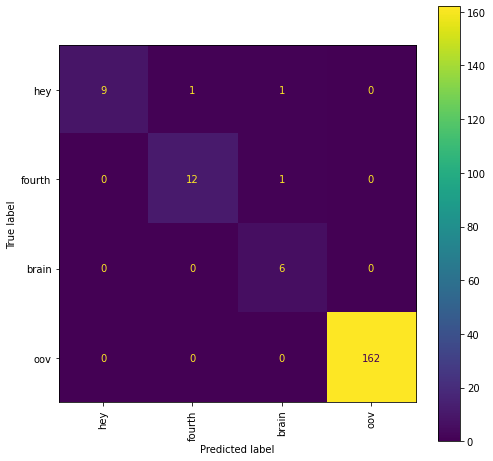

In [318]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0
classes = wake_words[:]
# oov
classes.append("oov")
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))

actual = []
predictions = []

model.eval()
# iterate over test data
pbar = tqdm(test_dl, total=len(test_dl), position=0, desc="Testing", leave=True)
for batch in test_dl:
    # move tensors to GPU if CUDA is available
    audio_data = batch['audio'].to(device)
    labels = batch['labels'].to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    mel_audio_data = audio_transform(audio_data)
    output = model(mel_audio_data)
    # calculate the batch loss
    loss = criterion(output, labels)
    # update test loss 
    test_loss += loss.item()*audio_data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(labels.shape[0]):
        label = labels.data[i]
        class_correct[label.long()] += correct[i].item()
        class_total[label.long()] += 1
        # for confusion matrix    
        actual.append(classes[labels.data[i].long().item()])
        predictions.append(classes[pred.data[i].item()])
        
# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=classes)
print(classification_report(actual, predictions))
cmp = ConfusionMatrixDisplay(cm, classes)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')


# average test loss
test_loss = test_loss/len(test_ds)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [88]:
%pwd

'D:\\GoogleDrive\\datasets\\hey-fourth-brain'

In [298]:
CHUNK = 500
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = sr
RECORD_MILLI_SECONDS = 750
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_MILLI_SECONDS/1000)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


In [299]:
sounddata = librosa.core.load(WAVE_OUTPUT_FILENAME, sr=sr, mono=True)[0]

In [300]:
Audio(sounddata, rate=sr)

In [301]:
# get duration 
# calculate length
sounddata_length = sounddata.size / sr * 1000

In [302]:
sounddata.size

12000

In [303]:
sounddata_length

750.0

In [304]:
inp = torch.from_numpy(sounddata).float().to(device)

In [305]:
inp.size()

torch.Size([12000])

In [306]:
delta_ms = int(inp.size(-1) / sr * 1000)

In [307]:
delta_ms

750

In [308]:
mel_audio_data = audio_transform(inp.unsqueeze(0))

In [309]:
mel_audio_data.size()

torch.Size([1, 3, 40, 61])

In [310]:
model.eval()
scores = model(mel_audio_data)

In [311]:
scores

tensor([[-13.8937,   5.7419, -12.1079,   7.8416]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [312]:
scores = F.softmax(scores, -1).squeeze(1)  # [num_frames x num_labels]

In [313]:
preds = scores[0].cpu().detach().numpy()
print([f"{x:.3f}" for x in preds.tolist()])
print(f"predicted label {np.argmax(preds)} - {classes[np.argmax(preds)]}")

['0.000', '0.109', '0.000', '0.891']
predicted label 3 - oov


# Stream Inference

In [314]:
model.eval()
audio_float_size = 32767
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* listening .. ")

inference_track = []

while True:
  frames = []
  
  for i in range(0, int(RATE / CHUNK * RECORD_MILLI_SECONDS/1000)):
      data = stream.read(CHUNK)
      frames.append(data)
  
  audio_data = np.frombuffer( b''.join(frames), dtype=np.int16).astype(np.float) / audio_float_size
  inp = torch.from_numpy(audio_data).float().to(device)
  mel_audio_data = audio_transform(inp.unsqueeze(0))
  scores = model(mel_audio_data)
  preds = scores[0].cpu().detach().numpy()
  # print([f"{x:.3f}" for x in preds.tolist()])
  pred_idx = np.argmax(preds)
  pred_word = classes[pred_idx]
  print(f"predicted label {pred_idx} - {pred_word}")
  if pred_word!='oov':
    if pred_word not in inference_track:
      inference_track.append(pred_word)
    if inference_track == wake_words:
      print(f"Wake word {' '.join(inference_track)} detected")
    if len(inference_track) >= len(wake_words):
      inference_track = [] # reset if oov
  else:
    inference_track = [] # reset if oov

* listening .. 


C:\Users\rajas\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


predicted label 3 - oov
predicted label 3 - oov
predicted label 1 - fourth
predicted label 1 - fourth
predicted label 1 - fourth
predicted label 3 - oov
predicted label 3 - oov
predicted label 1 - fourth
predicted label 1 - fourth
predicted label 1 - fourth
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 3 - oov
predicted label 1 - fourth
predicted label 1 - fourth
predicted label 3 - oov
predicted label 

KeyboardInterrupt: ignored